## Apply Machine Learning

In [1]:
# import packages and libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import shapefile as shp
import re
import json
import requests
import warnings
import geopandas as gpd
import scipy.stats as stats
import string
from pygeocoder import Geocoder
from collections import defaultdict
from collections import OrderedDict
from IPython.display import HTML
from shapely.geometry import Point
from sklearn.cluster import Birch
from sklearn.exceptions import DataConversionWarning
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats
import gmaps
import gmaps.datasets
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Specify formatting and ignore warnings

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [3]:
# Specify Formatting
display(HTML(r"<style>.output {display: flex; \
              align-items: center; \
              text-align: center;} \
              </style>"))

In [4]:
# Ignore warnings
warnings.simplefilter(action="ignore", \
                      category=FutureWarning)

warnings.filterwarnings(action='ignore', \
                        category=DataConversionWarning)

## Load Data

In [5]:
# Load data from cleaned csv files - (Alt_Fuel_DW.ipynb contains the Data Wrangling code)
alt_fuels_df = pd.read_csv('open_fuels.csv',parse_dates = True, error_bad_lines=False,low_memory=False)
veh_sales_df = pd.read_csv('veh_sales.csv',parse_dates = True, error_bad_lines=False,low_memory=False)

## Baseline Prediction for Time Series Forecasting

Establishing a baseline is essential on any time series forecasting problem.       
A baseline in performance gives an idea of how well all other models will actually perform on the problem.     
A baseline in forecast performance provides a point of comparison.      
If a model achieves performance at or below the baseline, the technique should be fixed or abandoned.

## Data for Baseline Prediction

In [6]:
# Create Dataframe st_df to contain ID and OpenYear for grouping stations
st_df=alt_fuels_df[['ID','OpenYear']]
# Create Dataframe st_cnt_year to contain Station Count by OpenYear 
st_cnt_year = st_df.groupby(['OpenYear']).ID.agg('count').to_frame('StCount').reset_index()
st_cnt_year = st_cnt_year[st_cnt_year.OpenYear >= 2000]
st_cnt_year = st_cnt_year[st_cnt_year.OpenYear != 2019]

In [7]:
st_cnt_year = st_cnt_year.rename(columns ={'OpenYear':'Year','StCount':'Count'})
ts_df = st_cnt_year.copy()
ts_df["Year"] = pd.to_datetime(ts_df["Year"].astype(str), format="%Y")
st_cnt_year.head()

,Year,Count
22,2000,41
23,2001,42
24,2002,74
25,2003,75
26,2004,85


In [8]:
ts_df.set_index('Year', inplace=True)
ts_df.index

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01'],
              dtype='datetime64[ns]', name='Year', freq=None)

In [9]:
ts = ts_df['Count']
ts.tail()

Year
2014-01-01    1389
2015-01-01    2274
2016-01-01    2278
2017-01-01    2008
2018-01-01    2526
Name: Count, dtype: int64

In [10]:
ts['2000-01-01']

41

In [11]:
from datetime import datetime
ts[datetime(2000,1,1)]

41

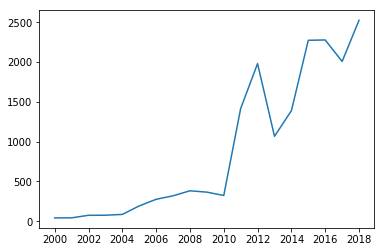

In [12]:
plt.plot(ts)

## Apply Linear Regression - Single Variable

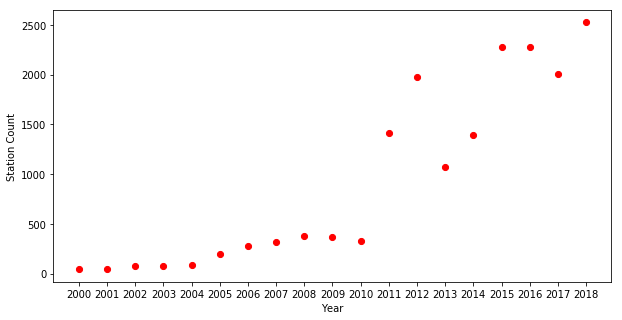

In [13]:
figure(figsize=(10,5))
plt.xlabel('Year')
plt.ylabel('Station Count')
plt.scatter(st_cnt_year.Year.astype('str'),st_cnt_year.Count, color='r', marker='.',s=150)

In [14]:
x = np.array(st_cnt_year[['Year']]).reshape((-1,1))
y = np.array(st_cnt_year[['Count']]).reshape((-1,1))
model = LinearRegression().fit(x,y)

r_sq = model.score(x,y)
print('Coefficient of Determination: ', r_sq)
print('Intercept: ', model.intercept_)
print('Slope: ', model.coef_)

Coefficient of Determination:  0.826227154062136
Intercept:  [-295120.23157895]
Slope:  [[147.34736842]]


In [15]:
y_pred = model.predict(x)
print('Predicted Response: ',x, y_pred, sep='\n')

Predicted Response: 
[[2000]
 [2001]
 [2002]
 [2003]
 [2004]
 [2005]
 [2006]
 [2007]
 [2008]
 [2009]
 [2010]
 [2011]
 [2012]
 [2013]
 [2014]
 [2015]
 [2016]
 [2017]
 [2018]]
[[-425.49473684]
 [-278.14736842]
 [-130.8       ]
 [  16.54736842]
 [ 163.89473684]
 [ 311.24210526]
 [ 458.58947368]
 [ 605.93684211]
 [ 753.28421053]
 [ 900.63157895]
 [1047.97894737]
 [1195.32631579]
 [1342.67368421]
 [1490.02105263]
 [1637.36842105]
 [1784.71578947]
 [1932.06315789]
 [2079.41052632]
 [2226.75789474]]


## Check Stationarity of a Time Series 

In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

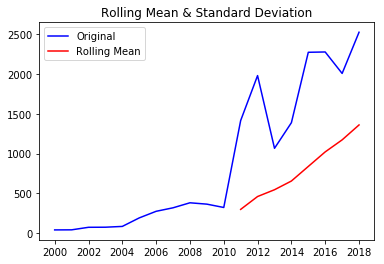

Results of Dickey-Fuller Test:
Test Statistic                  0.000000
p-value                         0.958532
#Lags Used                      8.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [17]:
test_stationarity(ts)

### The mean is clearly increasing with time and this is not a stationary series.

## Persistence Algorithm - naive forecast

The most common baseline method for supervised machine learning is the Zero Rule algorithm.
This algorithm predicts the average outcome in the case of regression. This could be used for time series, but does not respect the serial correlation structure in time series datasets.
The equivalent technique for use with time series dataset is the persistence algorithm.
The persistence algorithm uses the value at the previous time step (t) to predict the expected outcome at the next time step (t+1).

This dataset describes the yearly number of alternative fuel stations opened from 2000 onward.

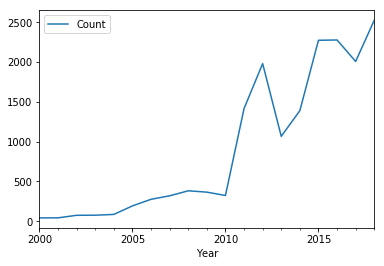

In [18]:
#st_cnt_year.plot('Year','Count')
ts.plot()
plt.legend()

## Step 1: Define the Supervised Learning Problem

The first step is to load the dataset and create a lagged representation. That is, given the observation at t, predict the observation at t+1.

In [19]:
# Create lagged dataset
#values = pd.DataFrame(st_cnt_year.Count)
values = pd.DataFrame(ts.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

      t  t+1
0   NaN   41
1  41.0   42
2  42.0   74
3  74.0   75
4  75.0   85


We can see that the first row (index 0) will have to be discarded as there was no observation prior to the first observation to use to make the prediction.      
From a supervised learning perspective, the t column is the input variable, or X, and the t+1 column is the output variable, or y.

## Step 2: Train and Test Sets

The next step is to separate the dataset into train and test sets.
We will keep the first 66% of the observations for “training” and the remaining 34% for evaluation. During the split, we are careful to exclude the first row of data with the NaN value.
Each of the train and test sets are then split into the input and output variables.

In [20]:
# Split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

## Step 3: Persistence Algorithm

We can define our persistence model as a function that returns the value provided as input.     

In [21]:
# persistence model
def model_persistence(x):
    return x

## Step 4: Make and Evaluate Forecast

Now we can evaluate this model on the test dataset.     
We do this using the walk-forward validation method.      
No model training or retraining is required, so in essence, we step through the test dataset time step by time step and get predictions.      
Once predictions are made for each time step in the training dataset, they are compared to the expected values and a Mean Squared Error (MSE) score is calculated.

In [22]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 340395.714


In this case, the error is more than 340000 over the test dataset.

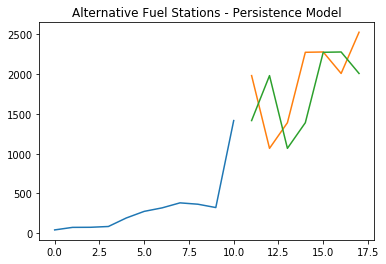

In [23]:
# plot predictions and expected results
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.title('Alternative Fuel Stations - Persistence Model')
pyplot.show()

Plot to show the training dataset and the diverging predictions from the expected values from the test dataset.

From the plot of the persistence model predictions, it is clear that the model is 1-step behind reality. There is a rising trend and year-to-year noise in the stations count, which highlights the limitations of the persistence technique.

## Autoregressive Integrated Moving Average Model

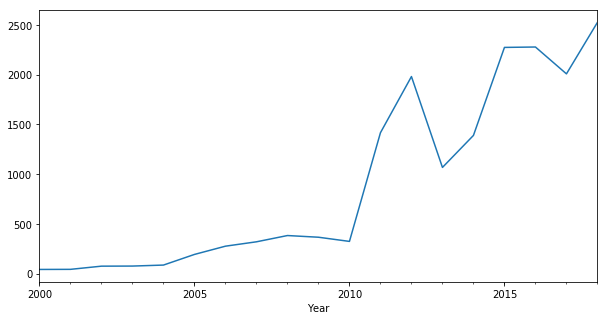

In [ ]:
figure(figsize=(10,5))
ts.plot()

We can see that the alternative fuel stations dataset has a clear trend.
This suggests that the time series is not stationary and will require differencing to make it stationary.   
Let’s also take a quick look at an autocorrelation plot of the time series.

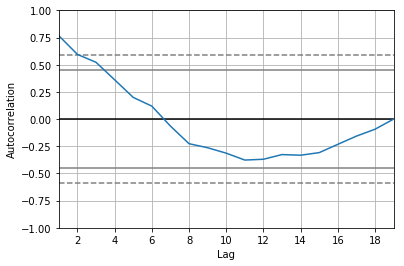

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts)
pyplot.show()
# p value can be 2 or 3 or 1 (determined by where the line touches the critical margin)

A good starting point for the AR parameter of the model may be 2.

/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1275: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k] * X[k:]).sum() / denom(k)


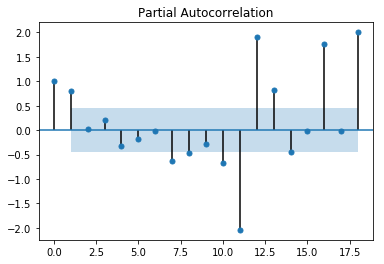

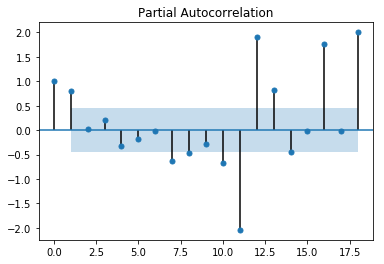

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ts, lags=20)

We see that about 9 fall out of range.
q can be 5,6,7,8 or 9

## ARIMA MODEL

The statsmodels library provides the capability to fit an ARIMA model.      
An ARIMA model can be created using the statsmodels library as follows:       
Define the model by calling ARIMA() and passing in the p, d, and q parameters.      
The model is prepared on the training data by calling the fit() function.      
Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.       
First, we fit an ARIMA(3,1,1) model. This sets the lag value to 3 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 1.       
When fitting the model, a lot of debug information is provided about the fit of the linear regression model. This can be turned off by setting the disp argument to 0.      

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Count   No. Observations:                   18
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -128.008
Method:                       css-mle   S.D. of innovations            285.628
Date:                Fri, 09 Aug 2019   AIC                            268.017
Time:                        21:24:52   BIC                            273.359
Sample:                    01-01-2001   HQIC                           268.753
                         - 01-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           143.1406     37.898      3.777      0.002      68.863     217.418
ar.L1.D.Count     0.8332      0.197      4.232      0.001       0.447       1.219
ar.L2.D.Count    -0.5349      0.236     

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


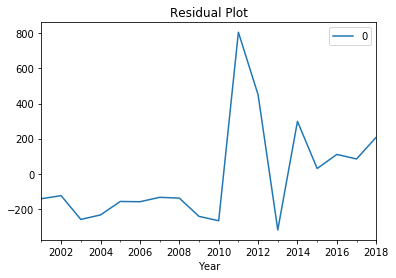

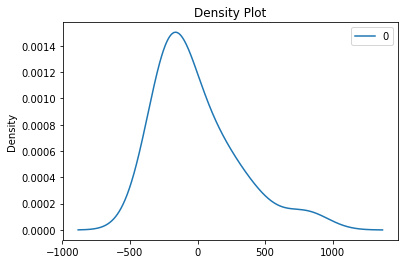

                0
count   18.000000
mean   -10.944758
std    295.466134
min   -320.256652
25%   -216.029793
50%   -136.712713
75%    103.628189
max    806.593338


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(ts, order=(3,1,1))
model_fit = model.fit()
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.title("Residual Plot")
pyplot.show()
residuals.plot(kind='kde')
pyplot.title('Density Plot')
pyplot.show()
print(residuals.describe())

Running the example prints a summary of the fit model. This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

Next, let’s look at how we can use the ARIMA model to make forecasts.

## Rolling Forecast ARIMA Model

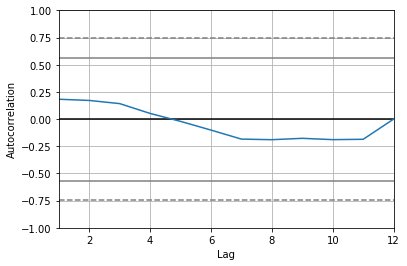

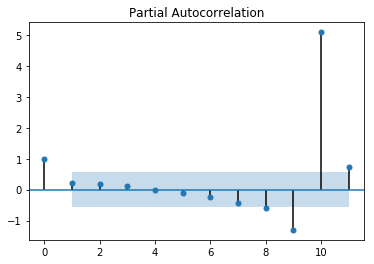

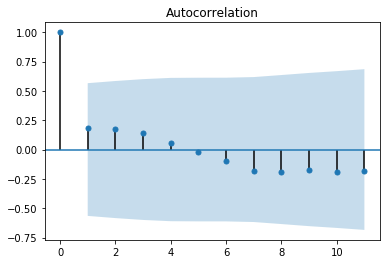

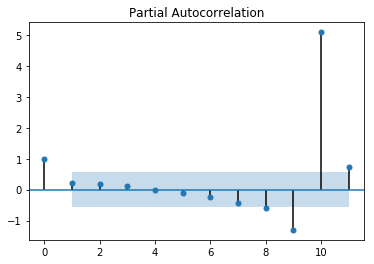

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
X = ts.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

# autocorrelation plot for the train set
autocorrelation_plot(history)
pyplot.show()
# p value can be 0 or 1
plot_acf(history)
# pacf plot for the train set
plot_pacf(history, lags=20)
# q value can be 2 or 3 or 4

predicted=736.277166, expected=1981.000000
predicted=2162.083684, expected=1067.000000
predicted=1453.029757, expected=1389.000000
predicted=1528.641705, expected=2274.000000
predicted=2006.533178, expected=2278.000000
predicted=2309.595233, expected=2008.000000
predicted=2285.939416, expected=2526.000000
Test MSE: 504355.001


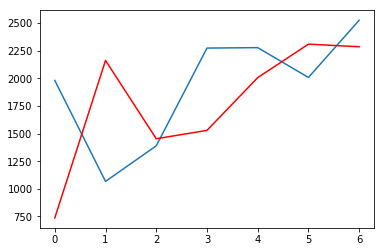

In [ ]:
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

In [ ]:
# one-step out-of sample forecast
forecast = model_fit.forecast(steps=5)[0]
forecast

array([2285.93941588, 2419.5423177 , 2553.14521953, 2686.74812136,
       2820.35102319])

## /---------------------------------------------------------------------------------------------------------/

# Time Series Forecasting with the Long Short-Term Memory Network (LSTM)

## LSTM forecast model for a one-step univariate time series

## Transform Time Series to Supervised Learning

In [ ]:
from pandas import DataFrame
from pandas import concat
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# transform to supervised learning
series = ts.copy()
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())


      0   0
0   0.0  41
1  41.0  42
2  42.0  74
3  74.0  75
4  75.0  85


In [ ]:
from pandas import Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# load dataset
print(series.head())
# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

Year
2000-01-01    41
2001-01-01    42
2002-01-01    74
2003-01-01    75
2004-01-01    85
Name: Count, dtype: int64
0      1
1     32
2      1
3     10
4    107
dtype: int64
0     42
1     74
2     75
3     85
4    192
dtype: int64


In [ ]:
from sklearn.preprocessing import MinMaxScaler
print(series)
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

Year
2000-01-01      41
2001-01-01      42
2002-01-01      74
2003-01-01      75
2004-01-01      85
2005-01-01     192
2006-01-01     275
2007-01-01     319
2008-01-01     382
2009-01-01     365
2010-01-01     323
2011-01-01    1416
2012-01-01    1981
2013-01-01    1067
2014-01-01    1389
2015-01-01    2274
2016-01-01    2278
2017-01-01    2008
2018-01-01    2526
Name: Count, dtype: int64
0   -1.000000
1   -0.999195
2   -0.973441
3   -0.972636
4   -0.964588
dtype: float64
0    41.0
1    42.0
2    74.0
3    75.0
4    85.0
dtype: float64


## LSTM Model Development

In [ ]:
import tensorflow 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

Using TensorFlow backend.


In [ ]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
j=2006
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Year=%d, Predicted=%f, Expected=%f' % (j+i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
